# Notebook Lecture 11: Feedback Linearization
@2025 ETH Zurich, Niclas Scheuer, Oscar von Lohneysen, Dejan Milojevic; Institute for Dynamic Systems and Control; Prof. Emilio Frazzoli

Picture Source: https://www.nasa.gov/wp-content/uploads/2023/02/wff-2021-011-002.jpeg?w=2048

# Pitch Plane Trajectory Tracking Control via Adaptive Feedback Linearization

Based on the work "[Pitch Plane Trajectory Tracking Control for Sounding Rockets via Adaptive Feedback Linearization](https://arxiv.org/html/2501.05285v1#S3)" - Pedro does Santos, Paulo Oliveira


## Motivation

The control of a sounding rocket is generally _underactuated_, since the number of control inputs is less than the number of degrees-of-freedom. 

The classical approach is to decouple attitude (orientation) and position dynamics. An external loop controls the position by generating attitude commands, which an internal control loop tracks.

This demonstration investigates the use of feedback linearization to jointly address position and attitude control.

In [1]:
import numpy as np

## Physical Model

### Reference Frames

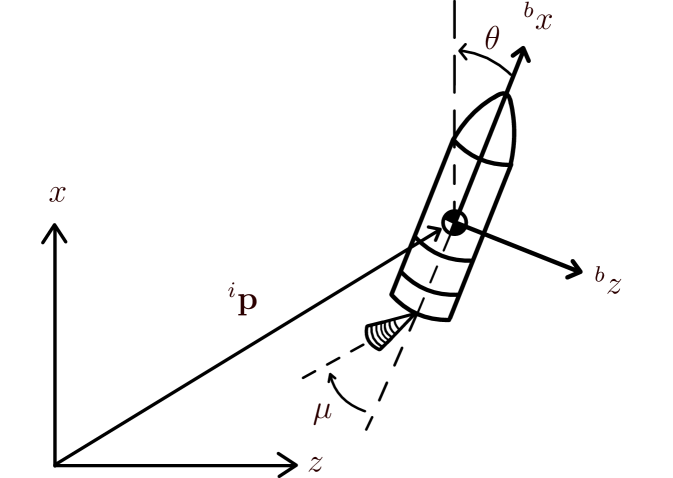


**Transformation between reference frames**

Reference frames: {inertial}, {body}

$$R_{i \leftarrow b} = \begin{bmatrix} \cos\theta & \sin\theta \\ -\sin\theta & \cos\theta \end{bmatrix}$$

### Constants
Constants regarding the launch vehicle used, more information in the start of section "Simulation".

In [ ]:
I_y = 3100 # kg*m^2
x_cm = 4.18 # m
l = x_cm
C_D = 0.1 
C_L = 0.034
g = 9.81 # m/s^2
I_sp0 = 300 # s
m0 = 1250
m_empty = 600

### Forces
**Gravity (Inertial Frame)**
$${}^{i}f_g = \begin{bmatrix} -mg \\ 0 \end{bmatrix}$$
with $g = \frac{g_0 R_E^2}{(R_E + x)^2}$, where $g_0$ is the gravitational constant, $R_E$ is Earth radius, $x$ is altitude.

**Thrust (Body Frame)** 
Thrust vector:
$${}^{b}f_p = \begin{bmatrix} T \cdot \cos\mu \\ T \cdot \sin\mu \end{bmatrix}$$
Pitching moment:
$$\tau_p = T\cdot \sin\mu \cdot l$$
with $l$ being the distance between the engine gimbal and the center of mass.

**Mass Flow**
$$\dot{m} = -\frac{T}{I_{sp0}g_0} - \frac{p_a A_e}{I_{sp0} g_0}$$

In [ ]:
def pressure(altitude: float) -> float:
    return 101325 * np.exp(-altitude / 8500)

def mass_dot(thrust_input: np.ndarray, pressure: float) -> float:
    return - thrust_input / (I_sp0 * g) - (pressure * np.pi * 0.5**2) / (I_sp0 * g)

**Aerodynamic Force (Body Frame)** 

Aerodynamic force vector:
$${}^{b}f_a = \begin{bmatrix} -\bar q C_A S \\ -\bar q C_N S \end{bmatrix}$$
with $C_A = C_D \cdot \cos\Lambda - C_L \cdot \sin\Lambda$ and $C_N = C_L \cdot \cos\Lambda + C_D \cdot \sin\Lambda$, the Lift and Drag coefficients $C_L$ and $C_D$, and angle of attack $\Lambda = atan2({}^{b}v_{rel,z}, {}^{b}v_{rel,x})$

Pitching moment:
$$\tau_a = {}^{b}f_{a_z} S M \bar d$$

In [ ]:
def aerodynamics(xdot: float, zdot: float, theta: float) -> np.ndarray:
    velocity = np.sqrt(xdot**2 + zdot**2)
    q = 0.5 * 1.225 * velocity**2

    gamma = np.arctan2(xdot, zdot)
    alpha = theta - gamma

    C_A = C_D * np.cos(alpha) - C_L * np.sin(alpha)
    C_N = C_L * np.cos(alpha) + C_D * np.sin(alpha)

    S = np.pi * 0.5**2 # m^2

    return np.array([-q * C_A * S, -q * C_N * S])

### Equations of Motion
The equations of motion can be expressed as the following nonlinear MIMO system:

$${\begin{bmatrix} x \\ \dot{x} \\ z \\ \dot{z} \\ \theta \\ q \end{bmatrix}}' = \begin{bmatrix} \dot{x} \\ -g + \frac{{}^{i}f_{a_x}}{m} \\ \dot{z} \\ \frac{{}^{i}f_{a_z}}{m} \\ q \\ \frac{\tau_a}{I_y} \end{bmatrix}
+ \begin{bmatrix} 0 & 0 \\ \frac{\cos\theta}{m} & \frac{\sin\theta}{m} \\ 0 & 0 \\ -\frac{\sin\theta}{m} & \frac{\cos\theta}{m} \\ 0 & 0 \\ 0 & \frac{l}{I_y} \end{bmatrix} 
\begin{bmatrix} T \cdot \cos\mu \\ T \cdot \sin\mu \end{bmatrix}$$
$$y = \begin{bmatrix} x \\ z \\ \theta \end{bmatrix}$$

In [4]:
def eom(t: float, state: np.ndarray, m: float, thrust_input: np.ndarray, f_a_input: np.ndarray, tau_a: float) -> np.ndarray:
    x, x_dot, z, z_dot, theta, theta_dot = state
    f_ax, f_az = f_a_input
    T_cos_mu, T_sin_mu = thrust_input

    dxdt = x_dot
    dx_dotdt = -g + f_ax / m + (np.cos(theta) * T_cos_mu + np.sin(theta) * T_sin_mu) / m
    dzdt = z_dot
    dz_dotdt = f_az / m + (-np.sin(theta) * T_cos_mu + np.cos(theta) * T_sin_mu) / m
    dthetadt = theta_dot
    dqdt = tau_a / I_y + (l * T_sin_mu) / I_y

    return np.array([dxdt, dx_dotdt, dzdt, dz_dotdt, dthetadt, dqdt])

## Inner Loop
The inner loop (attitude control) receives an altitude $x_d$ and pitch $\theta_d$ command. The errors $e_x = x - x_d$ and $e_{\theta} = \theta - \theta_d$ should be minimized.

$${\begin{bmatrix} e_x \\ \dot{e}_x \\ e_{\theta} \\ \dot{e}_{\theta} \end{bmatrix}}' = \begin{bmatrix} \dot{e}_x \\ -g + \frac{{}^{i}f_{a_x}}{m} - \ddot{x}_d \\ \dot{e}_{\theta} \\ \frac{\tau_a}{I_y} - \ddot{\theta}_d \end{bmatrix} + \begin{bmatrix} 0 & 0 \\ \frac{\cos\theta}{m} & \frac{\sin\theta}{m} \\ 0 & 0 \\ 0 & \frac{l}{I_y} \end{bmatrix} \begin{bmatrix} T \cdot \cos\mu \\ T \cdot \sin\mu \end{bmatrix}$$
$$y_{in} = \begin{bmatrix} e_x \\ e_{\theta} \end{bmatrix}$$

By taking the derivatives of $y_{in}$ with respect to time, we find that the input $u_{in}$ appears at relative degree $r_{in} = \{2, 2\}$. Therefore, we create the static state feedback law:
$$u_{in} = -\Lambda_{in}^{-1}(x_{in}) b_{in}(x_{in}) + \Lambda_{in}^{-1}(x_{in})v_{in}$$
with:
$$\Lambda_{in}(x_{in}) = \begin{bmatrix} \frac{\cos\theta}{m} & \frac{\sin\theta}{m} \\ 0 & \frac{l}{I_y} \end{bmatrix}$$
$$b_{in}(x_{in}) = \begin{bmatrix} -g + \frac{{}^{i}f_{a_x}}{m} - \ddot{x}_d \\ \frac{\tau_a}{I_y} - \ddot{\theta}_d \end{bmatrix}$$

In [ ]:
def u_in(t: float, state: np.ndarray, m: float, f_a_input: np.ndarray, tau_a: float, ref: np.ndarray, v_in: np.ndarray) -> np.ndarray:
    x, x_dot, z, z_dot, theta, theta_dot = state
    f_ax, f_az = f_a_input
    x_d, x_dot_d, x_dd_d, z_d, z_dot_d, z_dd_d, theta_d, theta_dot_d, theta_dd_d = ref

    Lambda = np.array([[np.cos(theta)/m, np.sin(theta)/m],[0, l/I_y]])
    b = np.array([[-g + f_ax/m - x_dd_d], [tau_a/I_y - theta_dd_d]])

    v_in = np.reshape(v_in, (2, 1))
    u_in = np.linalg.inv(Lambda) @ b + np.linalg.inv(Lambda) @ v_in

    return u_in.T

Applying the input $u_{in}$ to the system, it is linearized and the new dynamics are:

$${\begin{bmatrix} e_x \\ \dot{e}_x \\ e_{\theta} \\ \dot{e}_{\theta} \end{bmatrix}}' = \begin{bmatrix} 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 0 & 0 \end{bmatrix} \begin{bmatrix} e_x \\ \dot{e}_x \\ e_{\theta} \\ \dot{e}_{\theta} \end{bmatrix} + \begin{bmatrix} 0 & 0 \\ 1 & 0 \\ 0 & 0 \\ 0 & 1 \end{bmatrix} v_{in}$$
$$y_{in} = \begin{bmatrix} e_x \\ e_{\theta} \end{bmatrix}$$

Now, we may employ a more traditional PD controller:
$$v_{in} = \begin{bmatrix} -(1 + k_{1_x} k_{2_x})e_x - (k_{1_x} + k_{2_x}) \dot{e}_x \\ -(1 + k_{1_{\theta}} k_{2_{\theta}})e_{\theta} - (k_{1_{\theta}} + k_{2_{\theta}}) \dot{e}_{\theta} \end{bmatrix}$$

The gains are tuned to be: $k_{1_x} = 2.5$, $k_{2_x} = 4.5$, $k_{1_{\theta}} = 12$, $k_{2_{\theta}} = 10$

In [ ]:
def v_in(t: float, state: np.ndarray, ref: np.ndarray, k_1_x: float = 2.5, k_2_x: float = 4.5, k_1_theta: float = 12, k_2_theta: float = 10) -> np.ndarray:
    x, x_dot, z, z_dot, theta, theta_dot = state
    x_d, x_dot_d, x_dd_d, z_d, z_dot_d, z_dd_d, theta_d, theta_dot_d, theta_dd_d = ref

    e_x = x_d - x
    e_x_dot = x_dot_d - x_dot
    e_theta = theta_d - theta
    e_theta_dot = theta_dot_d - theta_dot

    return np.array([[
        -(1 + k_1_x*k_2_x) * e_x - (k_1_x + k_2_x) * e_x_dot
    ], [
        -(1 + k_1_theta*k_2_theta) * e_theta - (k_1_theta + k_2_theta) * e_theta_dot
    ]])

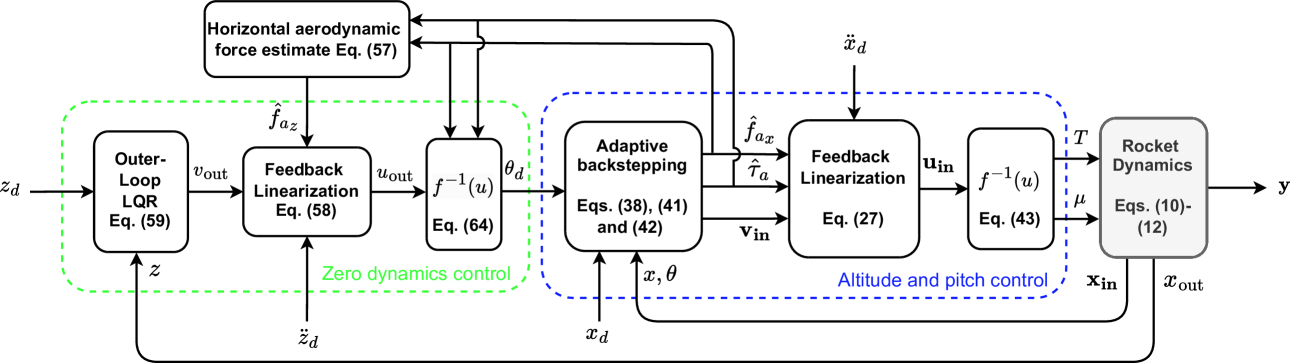

## Outer Loop
The outer loop provides the altitude $x_d$ and pitch $\theta_d$ commands to the inner loop in order to fulfill the horizontal distance requirement $z$. The rocket pitches as it gains altitude in order to enter orbit, this is known as a gravity turn. We first determine the inner-loop input $u_{in}^*$ that solves the _Problem of zeroing the output_.

$$0 = b_{in}(x_{in}^*) + \Lambda_{in}(x_{in}^*)u_{in}^*$$

$$u_{in}^* = \begin{bmatrix} \frac{1}{\cos\theta} \left(mg - {}^{i}f_{a_x} + m \ddot{x}_d + \frac{\sin\theta}{l}(\tau_a - I_y \ddot{\theta}_d) \right) \\ \frac{1}{l}(I_y \ddot{\theta}_d - \tau_a) \end{bmatrix}$$

Inserting this into the known EoM for $z$ yields equations describing the horizontal motion in the presence of stabilized inner dynamics:

$$\ddot{z} = \frac{{}^{i}f_{a_z}}{m} + a \cdot \tan\theta + \frac{b}{\cos\theta}$$

with $a = -g + \frac{{}^{i}f_{a_x}}{m} - \ddot{x}_d$ and $b = \frac{I_y \ddot{\theta}_d - \tau_a}{ml}$

In total, the outer dynamics are:

$$\dot{x}_{out} = \begin{bmatrix} \dot{e}_z \\ \frac{{}^{i}f_{a_z}}{m} - \ddot{z}_d \end{bmatrix} + \begin{bmatrix} 0 \\ 1 \end{bmatrix} u_{out}$$
$$y_{out} = e_z$$

### Feedback Linearization
Again, performing feedback linearization by deriving $y_{out}$, this time a SISO case, yields relative degree $r_{out} = 2$ and the control law:
$$u_{out} = \ddot{z}_d - \frac{{}^{i}f_{a_z}}{m} + v_{out}$$

and finally, the linearized outer loop dynamics:
$${\begin{bmatrix} e_z \\ \dot{e}_z \end{bmatrix}}' = \begin{bmatrix} 0 & 1 \\ 0 & 0 \end{bmatrix} \begin{bmatrix} e_z \\ \dot{e}_z \end{bmatrix} + \begin{bmatrix} 0 \\ 1 \end{bmatrix} v_{out}$$

For the outer loop $v_{out}$, a PID controller is used: $v_{out} = -k_z e_z -k_{\dot{z}} \dot{e}_z - k_i \int e_z$

It is solved using LQR $Q = \begin{bmatrix} 5 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \end{bmatrix}$ and $R = 60$ to yield: $k_z = 0.61$, $k_{\dot{z}} = 1.11$, $k_i = 0.13$.


In [ ]:
def u_out(t: float, state: np.ndarray, m: float, f_a_input: np.ndarray, ref: np.ndarray, v_out: float) -> float:
    x, x_dot, z, z_dot, theta, theta_dot = state
    f_ax, f_az = f_a_input
    x_d, x_dot_d, x_dd_d, z_d, z_dot_d, z_dd_d, theta_d, theta_dot_d, theta_dd_d = ref

    u_out = z_dd_d - f_az/m + v_out

    return u_out

def v_out(t: float, state: np.ndarray, ref: np.ndarray, k_z: float = 0.61, k_z_dot: float = 1.11, k_i: float = 0.13) -> float:
    x, x_dot, z, z_dot, theta, theta_dot = state
    x_d, x_dot_d, x_dd_d, z_d, z_dot_d, z_dd_d, theta_d, theta_dot_d, theta_dd_d = ref

    e_z = z_d - z
    e_z_dot = z_dot_d - z_dot

    v_out = -k_z * e_z - k_z_dot * e_z_dot

    return v_out

# Simulation
The below section concerns using the feedback linearization controllers to fulfill several mission scenarios. The rocket used is described below:

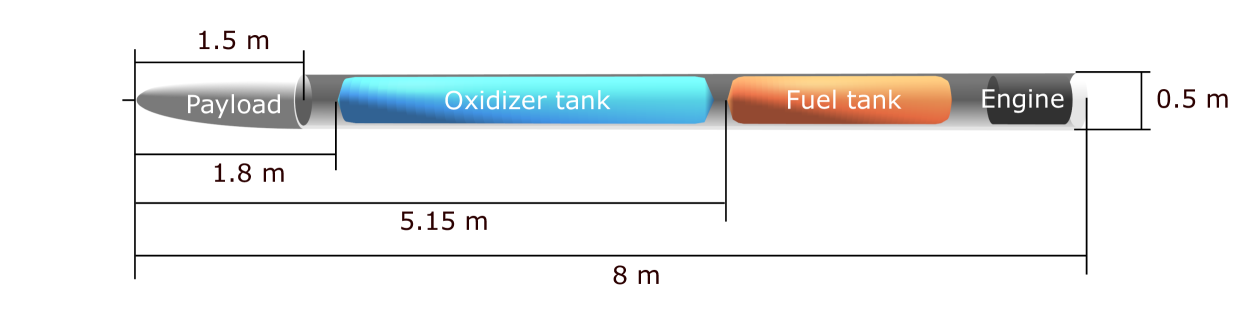

<table>
  <tr>
    <td>

<b>Main Vehicle Characteristics</b><br>
<table>
<tr><td>Length:</td><td>8 m</td></tr>
<tr><td>Max diameter:</td><td>0.5 m</td></tr>
<tr><td>Lift-off mass:</td><td>1250 kg</td></tr>
<tr><td>Dry mass:</td><td>650 kg</td></tr>
<tr><td>Dry inertia (I<sub>y</sub>):</td><td>3100 kg·m²</td></tr>
<tr><td>Dry x<sub>cm</sub>:</td><td>4.18 m</td></tr>
</table>


<b>Propulsion System Parameters</b><br>
<table>
<tr><td>Total propellant mass:</td><td>650 kg</td></tr>
<tr><td>I<sub>sp0</sub>:</td><td>300 s</td></tr>
<tr><td>Ox/Fuel mass ratio:</td><td>2.5</td></tr>
<tr><td>LOX density:</td><td>1141 kg/m³</td></tr>
<tr><td>RP1 density:</td><td>800 kg/m³</td></tr>
<tr><td>Oxidizer tank volume:</td><td>0.41 m³</td></tr>
<tr><td>Fuel tank volume:</td><td>0.23 m³</td></tr>
</table>


  </tr>
</table>

In [ ]:
# Initial State:

state = np.array([0, 0, 0, 0, 0, 0]) # [x, x_dot, z, z_dot, theta, theta_dot]
thrust_input = np.array([0, 0]) # [T_cos_mu, T_sin_mu]

